In [7]:
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import shutil
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Layer, Bidirectional, Conv2D, Flatten, BatchNormalization
from keras.layers import RepeatVector, concatenate
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from sklearn.ensemble import IsolationForest
import keras.backend as K
import tensorflow as tf

In [8]:
os.chdir('/home/ricky/RNNAE/')

data_GP = np.load('data_GP.npy', allow_pickle=True)
data_GP = np.array(data_GP)
print(data_GP.shape)


(1144, 10)


In [9]:
print(np.shape(list(data_GP[0][0:-3])))

(7, 185)


In [10]:
def create_input(split_portion=0.8, num_of_type=1):

    claimedtype = []

    input = [ [] for i in range(num_of_type+1)]
    input_train = [ [] for i in range(num_of_type+1)]
    input_test = [ [] for i in range(num_of_type+1)]
    type_train = [ [] for i in range(num_of_type+1)]
    type_test = [ [] for i in range(num_of_type+1)]

    for i in range(len(data_GP)):

        if 'Ia' in data_GP[i][-2]:
            claimedtype.append(0)
        if 'IIP' in data_GP[i][-2]:
            claimedtype.append(1)

    for i in range(len(claimedtype)):

        input[0].append(list(data_GP[i][0:-3]))

        if claimedtype[i] == 0:
            input[1].append(list(data_GP[i][0:-3]))
        if claimedtype[i] == 1:
            input[2].append(list(data_GP[i][0:-3]))

    for i in range(len(input)):
        input[i] = np.array(input[i])

        input_train[i] = input[i][:int(split_portion*len(input[i]))]
        input_test[i]  = input[i][int(split_portion*len(input[i])):]

        input[i] = input[i].transpose((0, 2, 1))
        input_train[i] = input_train[i].transpose((0, 2, 1))
        input_test[i] = input_test[i].transpose((0, 2, 1))
        '''input_train[i] = K.cast_to_floatx(input_train[i].transpose((0, 2, 1)))
        input_test[i] = K.cast_to_floatx(input_test[i].transpose((0, 2, 1)))'''

        type_train[i] = claimedtype[:int(split_portion*len(input[i]))]
        type_test[i]  = claimedtype[int(split_portion*len(input[i])):]

    for i in range(len(input)-1):
        print(input[i].shape, input_train[i].shape, input_test[i].shape)

    return input, input_train, input_test, type_train, type_test

def masking(input_tmp, split): # Poor function definition, input_tmp is problematic, split problem

    weight = []
    input_tmp = input_tmp

    for i in range(input_tmp.shape[0]):
        tmp1 = [1 for j in range(data_GP[i+split][-3])]
        #print(np.array(tmp1).shape)
        tmp2 = [0 for j in range(input_tmp.shape[1] - data_GP[i+split][-3])]
        tmp = np.hstack((tmp1, tmp2))
        weight.append(tmp)

    weight = np.array(weight)
    #print(weight.shape)

    mask = [weight for i in range(input_tmp.shape[2])]
    #print(np.array(mask).shape)
    mask = np.transpose(mask, (1, 2, 0))
    #print(np.array(mask).shape)
    #print(mask)

    return mask

def custom_loss(y_true, y_pred, mask):

    last_band_id = int((data_GP.shape[1] - 3 - 1)/2)+1

    y_true_masked = tf.math.multiply(y_true, mask)
    y_pred_masked = tf.math.multiply(y_pred, mask[:,:,1:last_band_id])
    
    mse = tf.keras.losses.mean_squared_error(y_true = y_true_masked[:,:,1:last_band_id], y_pred = y_pred_masked[:,:,:])

    return mse

def rnnae(input):

    input_seq = keras.Input(shape=(input[0].shape[1], input[0].shape[2]))
    input_mask = keras.Input(shape=(input[0].shape[1], input[0].shape[2]))
    #input_conc_phase = keras.Input(shape=(input[0].shape[1], 1))

    x = BatchNormalization()(input_seq)
    x = Bidirectional(GRU(185, activation='tanh', return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Bidirectional(GRU(50, activation='tanh', return_sequences=True))(x)
    x = BatchNormalization()(x)
    encoded = Bidirectional(GRU(6, activation='tanh', return_sequences=False))(x)

    x = RepeatVector(input[0].shape[1])(encoded)
    #merged = concatenate([x, input_conc_phase], axis=-1)
    #x = BatchNormalization()(merged)
    x = BatchNormalization()(x)
    x = Bidirectional(GRU(50, activation='tanh', return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Bidirectional(GRU(185, activation='tanh', return_sequences=True))(x)
    x = BatchNormalization()(x)
    decoded = TimeDistributed(Dense(input[0].shape[2]-3-1))(x)

    #autoencoder = keras.Model([input_seq, input_mask, input_conc_phase], decoded)
    autoencoder = keras.Model([input_seq, input_mask], decoded)
    autoencoder.add_loss(custom_loss(input_seq, decoded, input_mask))
    encoder = keras.Model(input_seq, encoded)

    opt = Adam(learning_rate=0.0001)

    autoencoder.compile(optimizer=opt, loss=None)
    #autoencoder.summary()

    return autoencoder, encoder

def rnnae_train(autoencoder, input_tmp, mask_tmp):

    callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience=50,
                       verbose=0, mode='min', baseline=None,
                       restore_best_weights=True)

    history = autoencoder.fit(x=[input_tmp, mask_tmp], y=None,
                            validation_split = 0.1,
                            epochs=1000,
                            verbose=1,
                            callbacks=[callbacks])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid()
    plt.ylim(0, 0.05)
    plt.show()

    return

def rnnae_test(autoencoder, input_tmp, mask_tmp):

    yhat = autoencoder.predict(x=[input_tmp, mask_tmp], verbose=1)
    yhat_loss = autoencoder.evaluate(x=[input_tmp, mask_tmp], y=None, verbose=1)

    return yhat

def latent_space_demo(encoder, input_tmp):

    latent_space = encoder.predict(input_tmp, verbose=1)

    print('latent space shape is', latent_space.shape)

    for i in range(latent_space.shape[1] - 1):
        plt.grid()
        plt.scatter(latent_space[:,i], latent_space[:,i+1], s=8)
        plt.show()
        plt.clf()

    return latent_space

def isolation_forest(latent_space, split):

    clf = IsolationForest(n_estimators=10, warm_start=True)
    anomaly = clf.fit_predict(latent_space)

    os.chdir('/home/ricky/RNNAE/RNN_anomaly_graph')

    for i, ano in enumerate(anomaly):
        if ano == -1:
            shutil.copy(f'/home/ricky/RNNAE/GP_graph/{data_GP[i+split][-1]}.pdf', f'/home/ricky/RNNAE/RNN_anomaly_graph/')

    return anomaly

def reconstruction_graph(input_tmp, yhat, split, filters=['u', 'g', 'i']):

    color1 = ['darkviolet', 'seagreen', 'crimson', 'maroon']
    color2 = ['darkmagenta', 'darkgreen', 'firebrick', 'darkred']

    for i in range(input_tmp.shape[0]):
        for j, filter in enumerate(filters):
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(1, 1, 1)

            plt.gca().invert_yaxis()

            # And a corresponding grid
            ax.grid(which='major', alpha=0.8)
            ax.grid(which='minor', alpha=0.3)

            plt.xlabel('Timestep', fontsize=15)
            plt.ylabel('Absolute Magnitude', fontsize=15)

            plt.xlim(-50, 185)

            plt.title(f'{data_GP[i+split][-1]}, {data_GP[i+split][-2]}, {filter}')

            #plt.errorbar(data_GP[i+split][0], data_GP[i+split][j+1], y_err=data_GP[i+split][j+4], fmt='v')

            plt.scatter(input_tmp[i,:,0], input_tmp[i,:,j+1], s=2, marker='o', color=color1[j], label='test data'.format('o'))
            plt.scatter(input_tmp[i,:,0], yhat[i,:,j], s=12, marker='X', color=color2[j], label='reconstruction'.format('x'))
            
            plt.legend()
            plt.show()
        plt.clf()

    return

In [11]:
def main():
    input, input_train, input_test, type_train, type_test = create_input()
    mask_train = masking(input_train[0], 0)
    mask_test = masking(input_test[0], int(0.8*(data_GP.shape[0])))
    autoencoder, encoder = rnnae(input)
    rnnae_train(autoencoder, input_train[0], mask_train)
    yhat = rnnae_test(autoencoder, input_test[0], mask_test)
    latent_space = latent_space_demo(encoder, input_train[0])
    anomaly = isolation_forest(latent_space, 0)
    #reconstruction_graph(input_test[0], yhat, int(0.8*(data_GP.shape[0])))

(1144, 185, 7) (915, 185, 7) (229, 185, 7)
Epoch 1/1000
26/26 [==============================] - 15s 175ms/step - loss: 0.4529 - val_loss: 0.0245
Epoch 2/1000
26/26 [==============================] - 3s 98ms/step - loss: 0.0628 - val_loss: 0.0242
Epoch 3/1000
26/26 [==============================] - 3s 104ms/step - loss: 0.0471 - val_loss: 0.0245
Epoch 4/1000
26/26 [==============================] - 3s 101ms/step - loss: 0.0398 - val_loss: 0.0250
Epoch 5/1000
26/26 [==============================] - 3s 99ms/step - loss: 0.0329 - val_loss: 0.0254
Epoch 6/1000
26/26 [==============================] - 3s 101ms/step - loss: 0.0309 - val_loss: 0.0274
Epoch 7/1000
26/26 [==============================] - 3s 103ms/step - loss: 0.0312 - val_loss: 0.0245
Epoch 8/1000
26/26 [==============================] - 3s 99ms/step - loss: 0.0276 - val_loss: 0.0260
Epoch 9/1000
26/26 [==============================] - 3s 102ms/step - loss: 0.0269 - val_loss: 0.0240
Epoch 10/1000
26/26 [====================

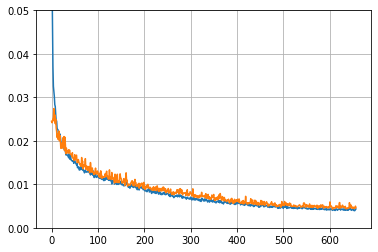

29/29 [==============================] - 2s 23ms/step
latent space shape is (915, 12)


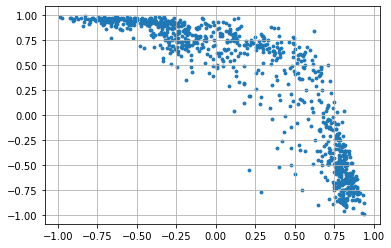

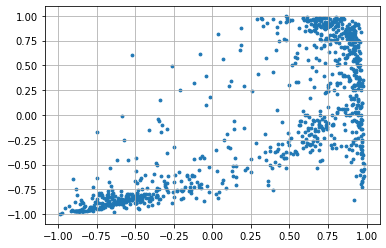

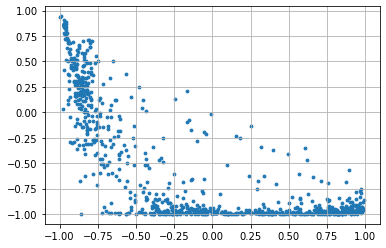

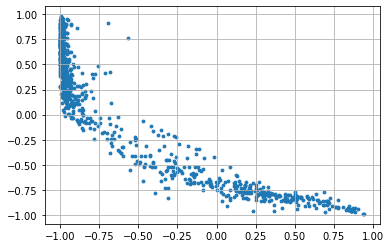

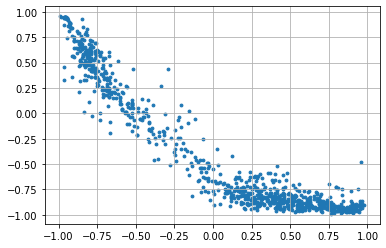

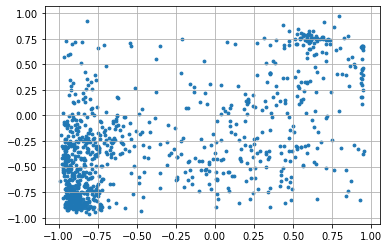

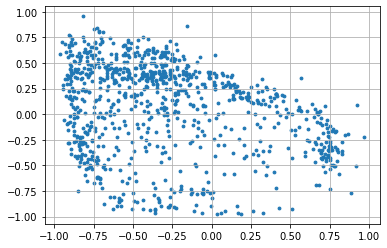

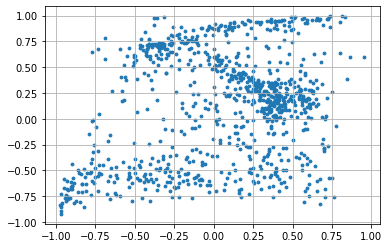

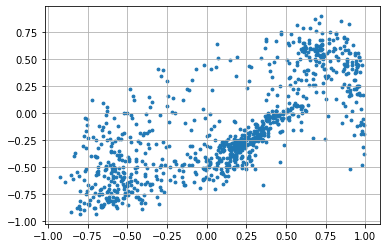

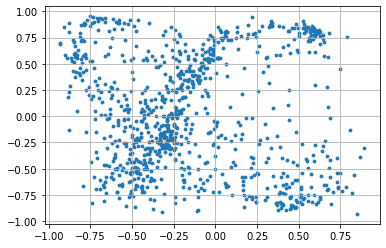

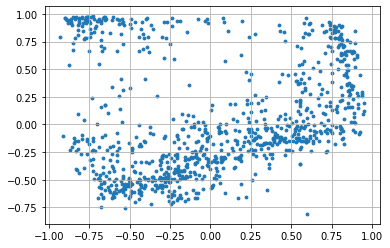

<Figure size 432x288 with 0 Axes>

In [12]:
if __name__ == '__main__':
    main()